In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from packaging import version
from tensorflow.keras import layers, models, backend as k
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error as MSE, confusion_matrix
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
import re
import string
import time

In [2]:
# https://www.tensorflow.org/datasets/splits
# The full 'train' and 'test' splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True, split=ri, as_supervised=True)
text_only_dataset_all = dataset_all.map(lambda x, y: x)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.S7XOXI_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.S7XOXI_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [3]:
# Downloading and preparing dataset
tfds.as_dataframe(dataset_all.take(10), info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [4]:
# Check the categories
categories = dict(enumerate(info.features["label"].names))
print(f'Dictionary: ', categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [5]:
# Review Class Balance
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [6]:
# Custom stopwords function
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase, r'[%s]' % re.escape(string.punctuation), '')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*', '')

In [7]:
nltk.download('stopwords', quiet=True)
STOPWORDS = stopwords.words("english")

In [11]:
# Text Vectorization and Vocabulary Adaptation
def text_vectorization_and_adapt(text_dataset, max_tokens=None, standardize_fn=None, output_sequence_length=None):
    text_vectorization = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        standardize=standardize_fn,
        output_sequence_length=output_sequence_length
    )
    text_vectorization.adapt(text_dataset)
    return text_vectorization

In [16]:
# Create and compile the CNN 1D model
def create_model(vocab_size, output_sequence_length):
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.Conv1D(128, 3, activation='relu')(embedded)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [17]:
# Train and evaluate the model
def train_and_evaluate_model(vocab_size, text_vectorization, output_sequence_length, model_name):
    print(f"Starting experiment: {model_name} with vocab size {vocab_size}")

    # Prepare the dataset
    def vectorize_text(text, label):
        text = text_vectorization(text)
        return text, label

    vectorized_dataset = dataset_all.map(vectorize_text)
    vectorized_dataset = vectorized_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Split the dataset
    dataset_size = len(list(vectorized_dataset))
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset = vectorized_dataset.take(train_size).batch(32)
    val_dataset = vectorized_dataset.skip(train_size).take(val_size).batch(32)

    # Train the model
    model = create_model(vocab_size, output_sequence_length)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}.h5", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
    start_time = time.time()
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=callbacks)
    training_time = time.time() - start_time

    # Evaluate on validation dataset
    val_loss, val_accuracy = model.evaluate(val_dataset)

    # Load the best model and evaluate on validation dataset
    model = models.load_model(f"{model_name}.h5")
    test_loss, test_accuracy = model.evaluate(val_dataset)

    # Collect final train accuracy and loss
    train_acc = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]

    return {
        'model_name': model_name,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'train_time': training_time,
        'val_acc': val_accuracy,
        'val_loss': val_loss,
        'test_acc': test_accuracy,
        'test_loss': test_loss,
        'history': history  # Ensure history is returned
    }


In [18]:
# Experiment with unedited and edited vocabularies
experiments = [
    {"name": "unedited", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100},
    {"name": "edited", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": custom_stopwords, "output_sequence_length": 100},
    {"name": "unedited_fixed_length", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100},
    {"name": "edited_fixed_length", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": custom_stopwords, "output_sequence_length": 100}
]


In [19]:
# Collecting results for the model
all_results = []
for experiment in experiments:
    for vocab_size in experiment["vocab_sizes"]:
        try:
            text_vectorization = text_vectorization_and_adapt(
                dataset_all.map(lambda text, label: text),
                max_tokens=vocab_size,
                standardize_fn=experiment["standardize_fn"],
                output_sequence_length=experiment["output_sequence_length"]
            )
            results = train_and_evaluate_model(vocab_size, text_vectorization, experiment["output_sequence_length"], experiment["name"])
            all_results.append(results)
        except ValueError as e:
            print(f"Error with vocab_size {vocab_size}: {e}")

Starting experiment: unedited with vocab size 5000
Epoch 1/200
3190/3190 [==============================] - 29s 7ms/step - loss: 0.4739 - accuracy: 0.8309 - val_loss: 0.3451 - val_accuracy: 0.8805
Epoch 2/200
  25/3190 [..............................] - ETA: 14s - loss: 0.3526 - accuracy: 0.8875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3190/3190 [==============================] - 15s 5ms/step - loss: 0.3429 - accuracy: 0.8887 - val_loss: 0.3365 - val_accuracy: 0.8865
Epoch 3/200
3190/3190 [==============================] - 15s 5ms/step - loss: 0.3263 - accuracy: 0.8976 - val_loss: 0.3583 - val_accuracy: 0.8825
Epoch 4/200
3190/3190 [==============================] - 15s 5ms/step - loss: 0.3235 - accuracy: 0.8989 - val_loss: 0.4098 - val_accuracy: 0.8663
Epoch 5/200
798/798 [==============================] - 3s 3ms/step - loss: 0.3365 - accuracy: 0.8865
Starting experiment: unedited with vocab size 10000
Epoch 1/200
3190/3190 [==============================] - 26s 8ms/step - loss: 0.4734 - accuracy: 0.8280 - val_loss: 0.3411 - val_accuracy: 0.8839
Epoch 2/200
3190/3190 [==============================] - 16s 5ms/step - loss: 0.3139 - accuracy: 0.9003 - val_loss: 0.3111 - val_accuracy: 0.8945
Epoch 3/200
3190/3190 [==============================] - 16s 5ms/step - loss: 0.2911 - accuracy: 0.9102 - val_loss: 0.3172 - val_

In [20]:
# Adjust display settings for better alignment
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Create a DataFrame to display the results
df = pd.DataFrame(all_results)

# Display the DataFrame
print(df)

               model_name  train_acc  train_loss  train_time   val_acc  val_loss  test_acc  test_loss                                            history
0                unedited   0.900980    0.320824   89.320003  0.863754  0.418562  0.886481   0.336546  <keras.src.callbacks.History object at 0x7b15e...
1                unedited   0.921973    0.276651  105.381414  0.871865  0.492577  0.894475   0.311083  <keras.src.callbacks.History object at 0x7b15e...
2                unedited   0.936393    0.226941   92.535884  0.894318  0.403703  0.897688   0.313224  <keras.src.callbacks.History object at 0x7b14f...
3                  edited   0.916957    0.284348   86.182464  0.876959  0.461323  0.894632   0.317024  <keras.src.callbacks.History object at 0x7b14f...
4                  edited   0.949540    0.193106  118.815361  0.877155  0.509703  0.892281   0.323555  <keras.src.callbacks.History object at 0x7b14e...
5                  edited   0.947571    0.197283   91.195426  0.877586  0.475985  

Model: unedited, Vocab Size: unedited, History Data: {'loss': [0.47393107414245605, 0.3428652882575989, 0.3262963593006134, 0.32350584864616394, 0.3208242952823639], 'accuracy': [0.8308679461479187, 0.8887343406677246, 0.8976293206214905, 0.8988929986953735, 0.9009796380996704], 'val_loss': [0.3450608253479004, 0.336546391248703, 0.35826534032821655, 0.4097585082054138, 0.4185624420642853], 'val_accuracy': [0.8805250525474548, 0.8864811658859253, 0.8825235366821289, 0.8663401007652283, 0.8637539148330688]}
Model: unedited, Vocab Size: unedited, History Data: {'loss': [0.47336164116859436, 0.3139481842517853, 0.2911033630371094, 0.29033783078193665, 0.2821511924266815, 0.2766507565975189], 'accuracy': [0.8279682397842407, 0.9002645015716553, 0.9102370738983154, 0.913440465927124, 0.9180838465690613, 0.9219729900360107], 'val_loss': [0.34111183881759644, 0.31108272075653076, 0.3171687424182892, 0.34609901905059814, 0.40004265308380127, 0.4925772547721863], 'val_accuracy': [0.883894979953

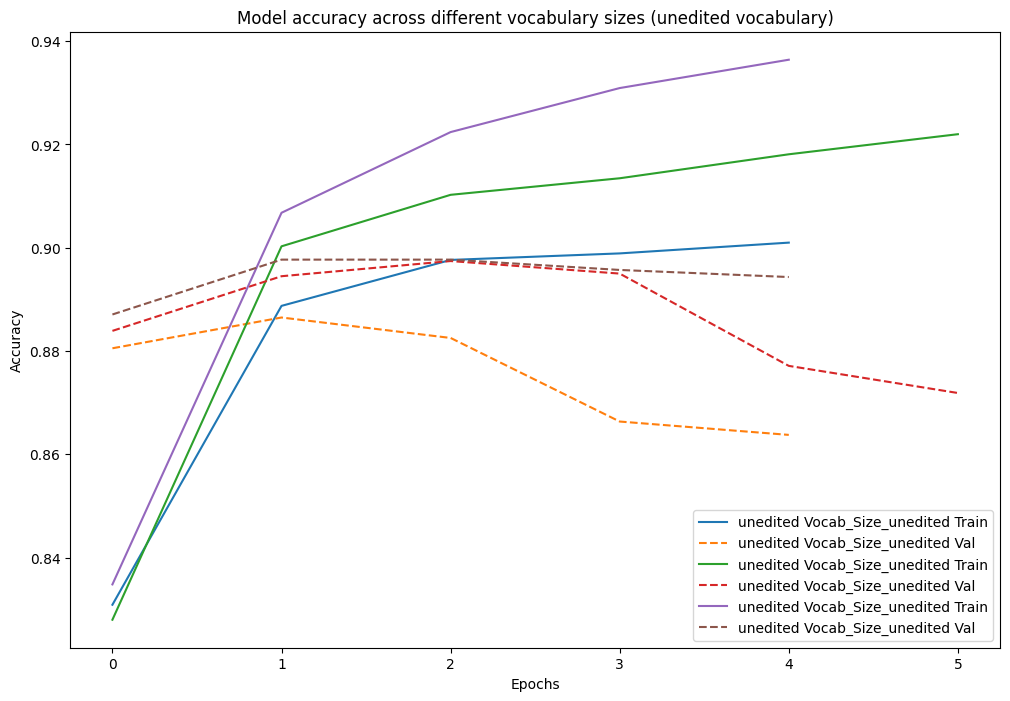

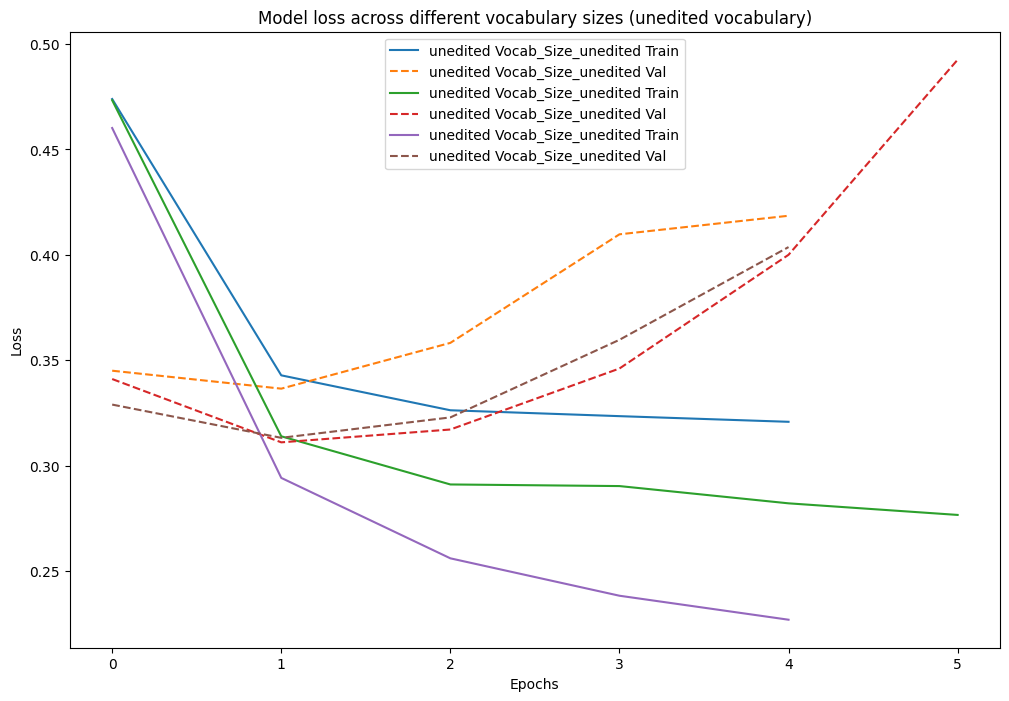

Model: edited, Vocab Size: edited, History Data: {'loss': [0.4348906874656677, 0.32012563943862915, 0.30294865369796753, 0.29585227370262146, 0.2843482196331024], 'accuracy': [0.8498138785362244, 0.8995885848999023, 0.9082974195480347, 0.9122354984283447, 0.9169572591781616], 'val_loss': [0.33829641342163086, 0.31702423095703125, 0.33644992113113403, 0.37290942668914795, 0.46132275462150574], 'val_accuracy': [0.8852664828300476, 0.8946316838264465, 0.8924372792243958, 0.8893417119979858, 0.8769592642784119]}
Model: edited, Vocab Size: edited, History Data: {'loss': [0.43203434348106384, 0.29792189598083496, 0.2654830813407898, 0.24780675768852234, 0.2295365333557129, 0.21401236951351166, 0.19310633838176727], 'accuracy': [0.8513126969337463, 0.9076312780380249, 0.920474112033844, 0.9278702735900879, 0.935873806476593, 0.9425548315048218, 0.9495396018028259], 'val_loss': [0.3278958201408386, 0.3235546052455902, 0.3606667220592499, 0.3457165062427521, 0.4060283899307251, 0.44568896293640

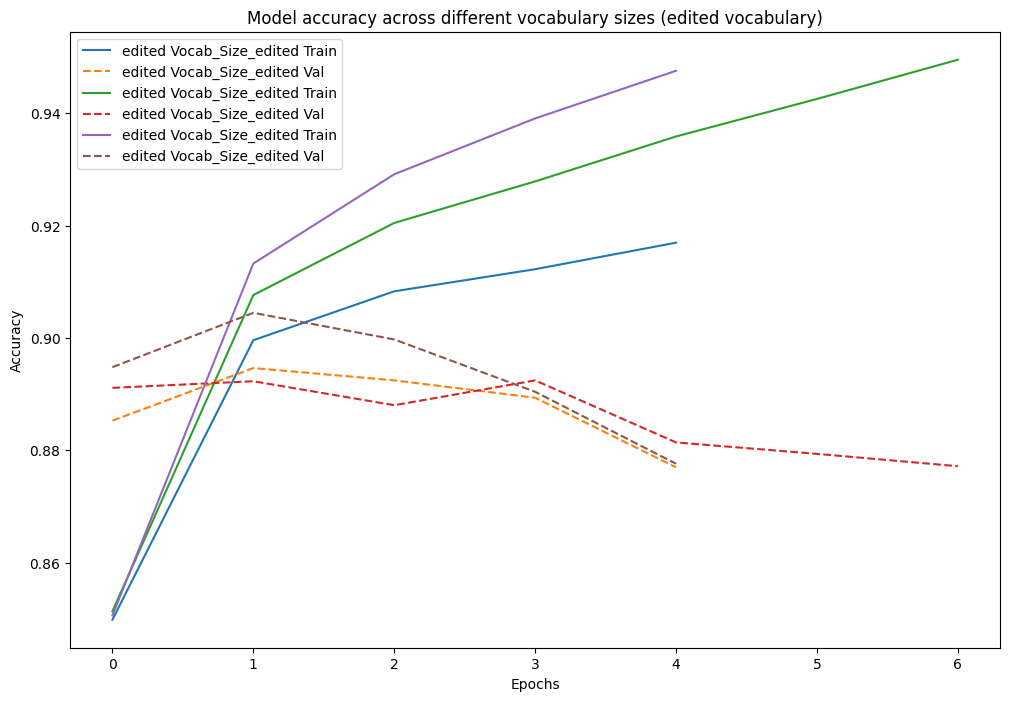

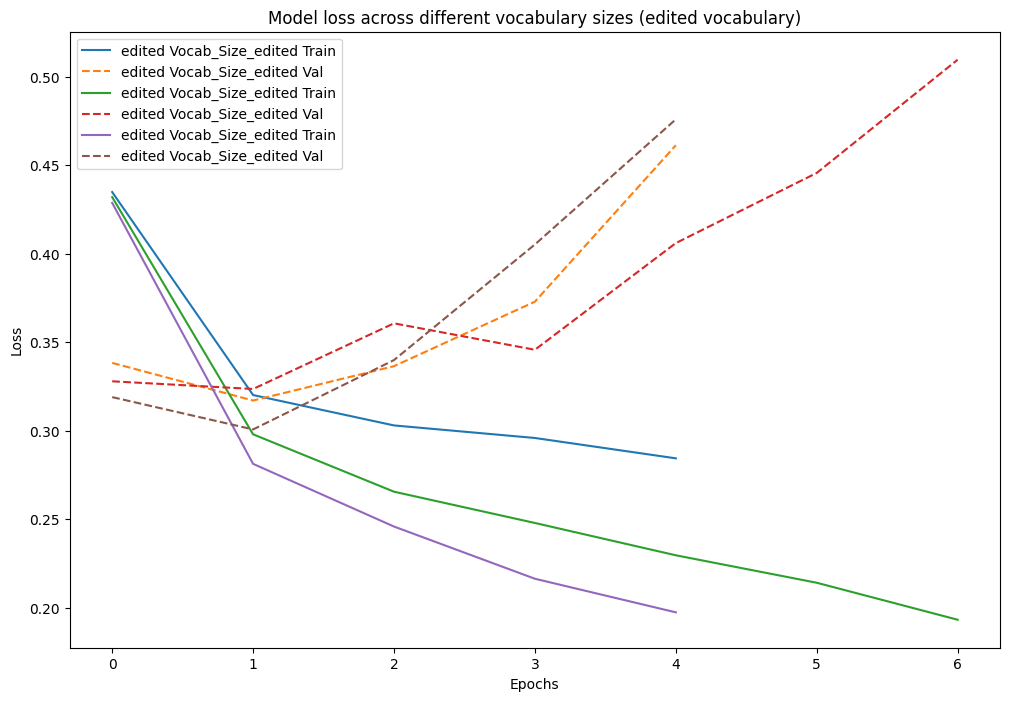

Model: unedited_fixed_length, Vocab Size: unedited_fixed_length, History Data: {'loss': [0.47549039125442505, 0.3412872552871704, 0.32781654596328735, 0.3261340260505676, 0.3260200321674347], 'accuracy': [0.8277233839035034, 0.8892829418182373, 0.8958562016487122, 0.8991379141807556, 0.8997061252593994], 'val_loss': [0.34477871656417847, 0.33534517884254456, 0.34755897521972656, 0.34810900688171387, 0.3941265940666199], 'val_accuracy': [0.8797805905342102, 0.8862069249153137, 0.8859717845916748, 0.8859717845916748, 0.8701802492141724]}
Model: unedited_fixed_length, Vocab Size: unedited_fixed_length, History Data: {'loss': [0.4710380733013153, 0.3136758804321289, 0.28939422965049744, 0.2871438264846802, 0.2833622097969055, 0.27706587314605713], 'accuracy': [0.8298393487930298, 0.9002938866615295, 0.9094533920288086, 0.9134502410888672, 0.9163694977760315, 0.9204643368721008], 'val_loss': [0.32856348156929016, 0.31659966707229614, 0.3562675714492798, 0.38421377539634705, 0.38302728533744

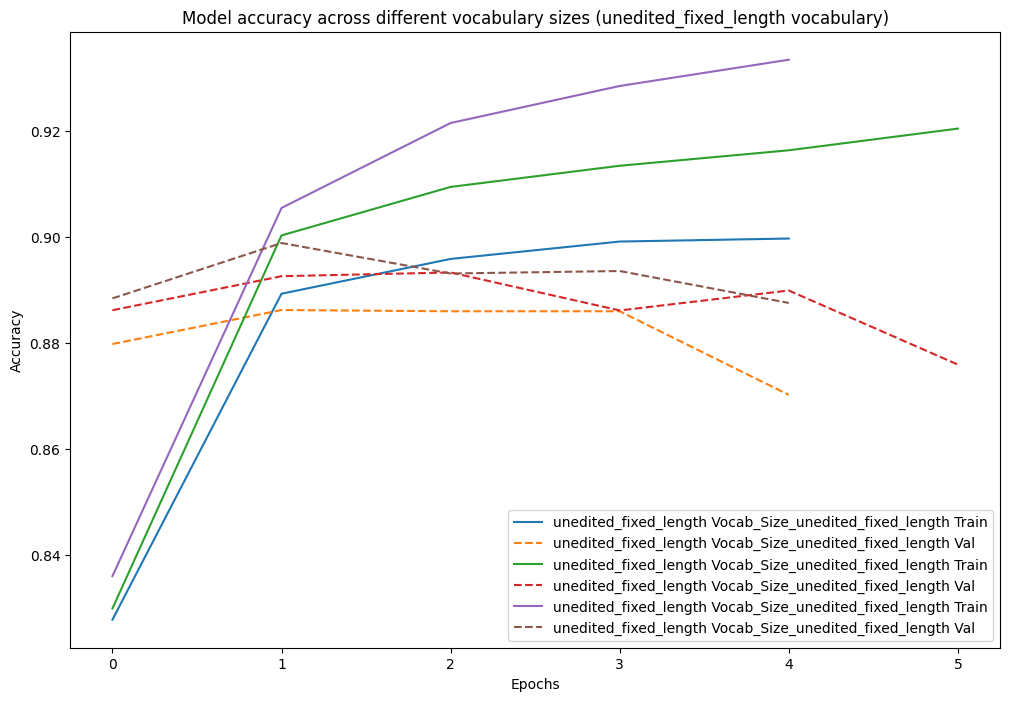

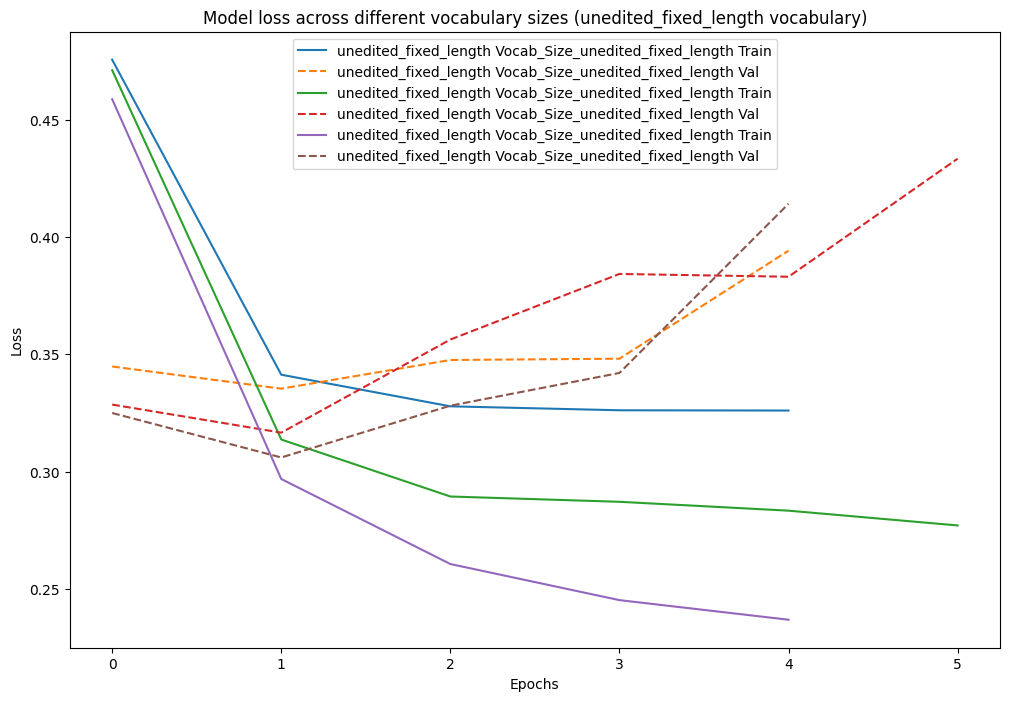

Model: edited_fixed_length, Vocab Size: edited_fixed_length, History Data: {'loss': [0.4489384591579437, 0.31857287883758545, 0.29801028966903687, 0.28610724210739136, 0.27906036376953125, 0.26527631282806396, 0.258461058139801], 'accuracy': [0.8420748710632324, 0.8990301489830017, 0.9082974195480347, 0.9140282273292542, 0.9183875322341919, 0.9238831996917725, 0.9274294376373291], 'val_loss': [0.34482628107070923, 0.36707228422164917, 0.3759540319442749, 0.3425941467285156, 0.39711934328079224, 0.45123812556266785, 0.493881493806839], 'val_accuracy': [0.8833855986595154, 0.8748040795326233, 0.878017246723175, 0.8903604745864868, 0.8815830945968628, 0.8824451565742493, 0.8793495297431946]}
Model: edited_fixed_length, Vocab Size: edited_fixed_length, History Data: {'loss': [0.4406875967979431, 0.2975558340549469, 0.2696053683757782, 0.24842552840709686, 0.23089540004730225], 'accuracy': [0.8452292084693909, 0.9069357514381409, 0.9190145134925842, 0.92811518907547, 0.9354819655418396], 'v

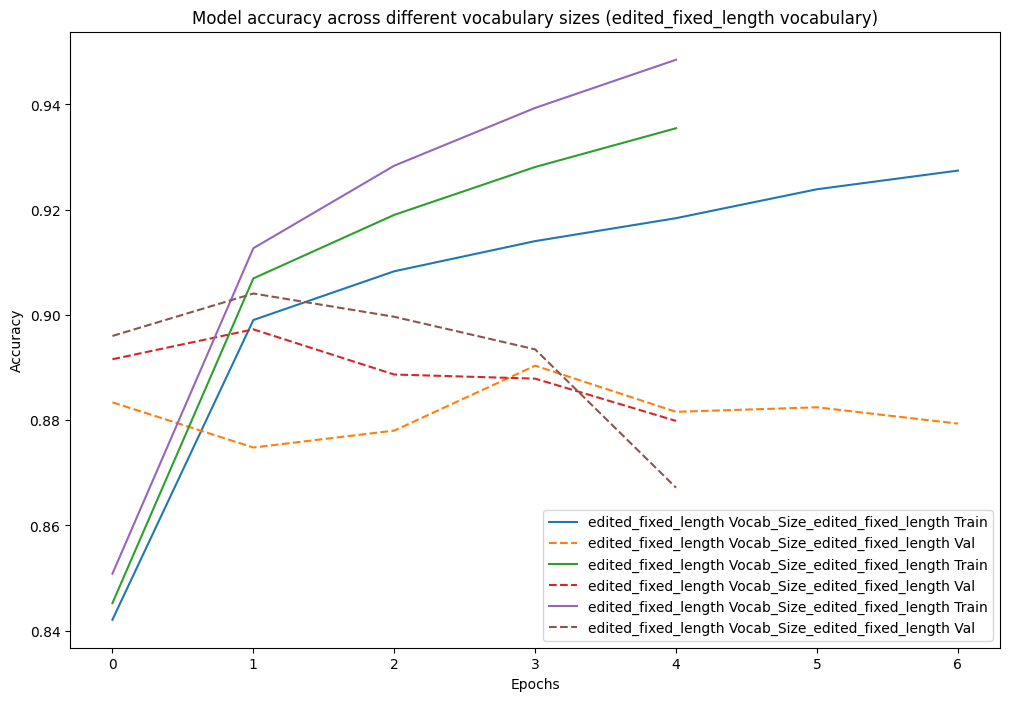

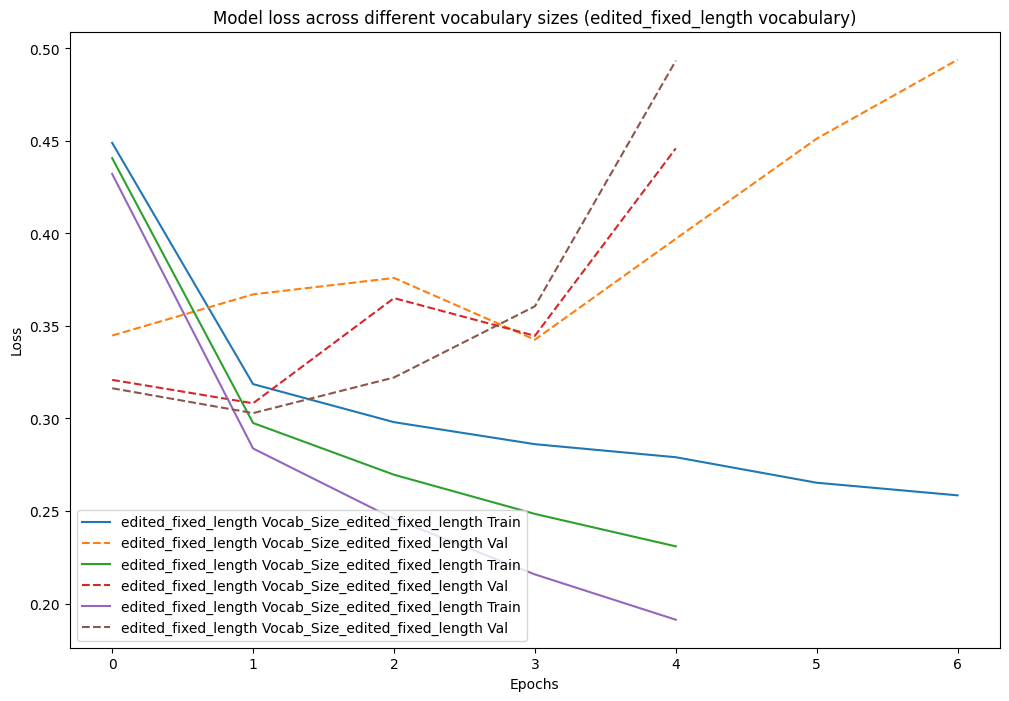

In [21]:
# Function to plot accuracy and loss for different vocabulary sizes and experiments
def plot_results(results_df):
    # Iterate over each unique experiment name
    for experiment_name in results_df['model_name'].unique():
        # Filter the DataFrame for the current experiment
        experiment_df = results_df[results_df['model_name'] == experiment_name]

        # Plot accuracy
        plt.figure(figsize=(12, 8))
        for index, row in experiment_df.iterrows():
            history = row['history']
            vocab_size = row['model_name']

            # Debugging: Print the contents of the history object
            print(f"Model: {experiment_name}, Vocab Size: {vocab_size}, History Data: {history.history}")

            if 'accuracy' in history.history and 'val_accuracy' in history.history:
                plt.plot(history.history['accuracy'], label=f'{experiment_name} Vocab_Size_{vocab_size} Train')
                plt.plot(history.history['val_accuracy'], label=f'{experiment_name} Vocab_Size_{vocab_size} Val', linestyle='--')
            else:
                print(f"Missing keys in history for model: {experiment_name}, vocab size: {vocab_size}")

        plt.title(f"Model accuracy across different vocabulary sizes ({experiment_name} vocabulary)")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

        # Plot loss
        plt.figure(figsize=(12, 8))
        for index, row in experiment_df.iterrows():
            history = row['history']
            vocab_size = row['model_name']

            if 'loss' in history.history and 'val_loss' in history.history:
                plt.plot(history.history['loss'], label=f'{experiment_name} Vocab_Size_{vocab_size} Train')
                plt.plot(history.history['val_loss'], label=f'{experiment_name} Vocab_Size_{vocab_size} Val', linestyle='--')
            else:
                print(f"Missing keys in history for model: {experiment_name}, vocab size: {vocab_size}")

        plt.title(f"Model loss across different vocabulary sizes ({experiment_name} vocabulary)")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Call the function with the DataFrame containing the results
plot_results(df)

1/1 [==============================] - 0s 86ms/step


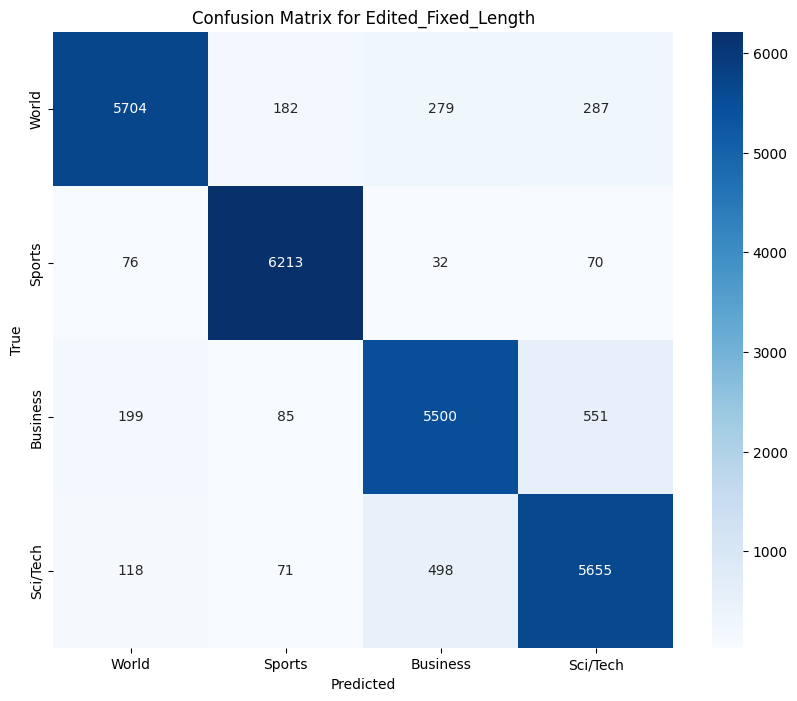

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix
def plot_confusion_matrix(model, vectorizer, dataset, model_name):
    # Vectorize the test data
    def vectorize_text(text, label):
        text = vectorizer(text)
        return text, label

    vectorized_dataset = dataset.map(vectorize_text)
    test_data = vectorized_dataset.skip(int(0.8 * len(list(vectorized_dataset)))).take(int(0.2 * len(list(vectorized_dataset)))).batch(32)

    # Get true labels and predictions
    true_labels = []
    predictions = []

    for text_batch, label_batch in test_data:
        preds = model.predict(text_batch)
        predictions.extend(tf.argmax(preds, axis=1).numpy())
        true_labels.extend(label_batch.numpy())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Load the best models
edited_fixed_length_model = models.load_model("edited_fixed_length.h5")
# Plot confusion matrix for Edited_Fixed_Length model
plot_confusion_matrix(edited_fixed_length_model, text_vectorization_and_adapt(dataset_all.map(lambda text, label: text), max_tokens=20000, standardize_fn=custom_stopwords, output_sequence_length=100), dataset_all, "Edited_Fixed_Length")


In [24]:
# Define function to evaluate the models
def evaluate_model(model, vectorizer, dataset):
    # Vectorize the test data
    def vectorize_text(text, label):
        text = vectorizer(text)
        return text, label

    vectorized_dataset = dataset.map(vectorize_text)
    test_data = vectorized_dataset.skip(int(0.8 * len(list(vectorized_dataset)))).take(int(0.2 * len(list(vectorized_dataset)))).batch(32)

    # Get true labels and predictions
    true_labels = []
    predictions = []

    for text_batch, label_batch in test_data:
        preds = model.predict(text_batch)
        predictions.extend(tf.argmax(preds, axis=1).numpy())
        true_labels.extend(label_batch.numpy())

    # Compute metrics
    f1 = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions, average='weighted')

    return f1, accuracy, recall


In [26]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
# Evaluate the Edited_Fixed_Length model
edited_fixed_length_vectorizer = text_vectorization_and_adapt(
    dataset_all.map(lambda text, label: text),
    max_tokens=20000,
    standardize_fn=custom_stopwords,
    output_sequence_length=100
)
edited_fixed_length_f1, edited_fixed_length_accuracy, edited_fixed_length_recall = evaluate_model(
    edited_fixed_length_model,
    edited_fixed_length_vectorizer,
    dataset_all
)

# Print results for Edited_Fixed_Length model
print(f"Edited_Fixed_Length Model - F1 Score: {edited_fixed_length_f1}, Accuracy: {edited_fixed_length_accuracy}, Recall: {edited_fixed_length_recall}")


1/1 [==============================] - 0s 17ms/step
Edited_Fixed_Length Model - F1 Score: 0.9040367435470286, Accuracy: 0.9040752351097179, Recall: 0.9040752351097179
